<a href="https://colab.research.google.com/github/seokiho/kisti-police/blob/main/jsonReader_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import csv
import json
import pandas as pd
import numpy as np
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity



In [ ]:


# JSON Data structure
#
#   "score": {
#     "-NOhScUFQniRJwhbp85s": {
#       "crm_set": 1,
#       "date_set": 1,
#       "dtime": "15:11:55",
#       "key": "-NOhScUFQniRJwhbp85s",
#       "score_cos": 52.81,
#       "score_lcs": 19.91,
#       "subj_set": 0,
#       "text_con": "2023. 2. 11. 09:30경 장소모르는 곳에서 피해자 김피해에게 아들 이철수라고 하며 카카오톡을 통하여 50만원을 입금해달라고 연락하였다.  이에 속은 피해자는 같은 날 10:20경 김범인 명의 국민은행 계좌(638010064222)로 50만원을 입금하였다.",
#       "whr_set": 1,
#       "word_set": 1
#     },


def json_to_csv(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # exraction list by fields' names
    fields = ["score_cos", "score_lcs", "text_con"]

    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(fields)

        for key, item in data["score"].items():  # extract only key of "score" data
            row = [item.get(field, None) for field in fields]
            writer.writerow(row)


# set the files' paths
input_file_path = "/content/gdrive/MyDrive/vltldtkdlxm312-default-rtdb-export.json"
output_file_path = "/content/gdrive/MyDrive/output_all.csv"

# JSON TO CSV
json_to_csv(input_file_path, output_file_path)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2350 entries, 0 to 2349
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score_cos  2350 non-null   float64
 1   score_lcs  2350 non-null   float64
 2   text_con   2350 non-null   object 
dtypes: float64(2), object(1)
memory usage: 55.2+ KB
      score_cos  score_lcs                                           text_con  \
0         52.81      19.91  2023. 2. 11. 09:30경 장소모르는 곳에서 피해자 김피해에게 아들 이철수...   
1         52.38      24.67  2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김피해에게 아...   
2         45.02      11.25  피혐의자는 2023. 2. 11. 09:30경 피해자에게 본인이 아들 이철수이며 카...   
3         48.91      20.77  2023. 2. 20. 09:30경 피해자는 아들로 사칭한 자가 카톡으로 '급히 돈...   
4         54.31       8.62  피혐의자는 2023. 2. 11. 09:30 경 장소 미상의 곳에서 아들 ‘철수’ ...   
...         ...        ...                                                ...   
2345      35.47      11.11  피혐의자는 2023. 2. 11. 09:30경 아들을 사칭하여 핸드폰이 고장나 연락

<Axes: xlabel='classification', ylabel='count'>

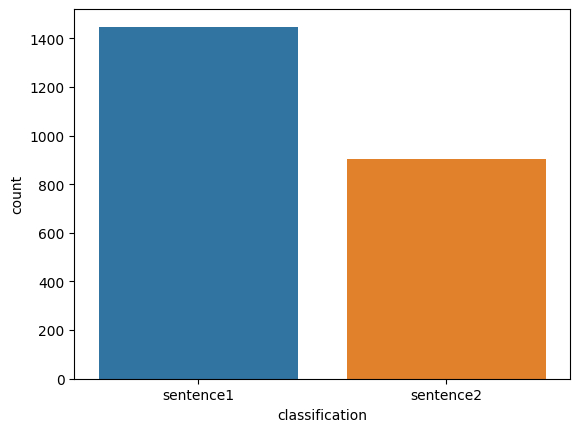

In [ ]:

input_csv_file = '/content/gdrive/MyDrive/output_all.csv'

data = pd.read_csv(input_csv_file, encoding="utf-8")

# EDA, no blank trunk data

data.info()

# text_con에는 두 가지 시나리오로 구성되므로 라벨링이 필요
# 텍스트 분류 기준은 답안 예시와 유사도 큰 것으로만 분류

# String a = "피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김피해에게 아들 이철수라고 하며 '급히 돈이 필요한데 휴대폰이 고장나서 OTP가 안되니 대신 송금해주면 집에서 돌려주겠다.'는 카카오톡 메시지를 보냈다. 피혐의자는 아들 이철수를 사칭하여 거짓말하였다. 피혐의자는 이에 속은 피해자로부터 같은 날 10:20경 김범인 명의 국민은행 계좌(638-01-0064-222)로 50만 원 교부받았다."
# String b = "피혐의자는 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 피해자 나피해(38세, 여)에게 KB저축은행 대출상담원 김지영 실장으로 속이며 'KB캐피탈 대출'을 상환하면 저금리로 대환할 수 있다고 하였다. 피혐의자는 KB저축은행 앱을 설치하고 대출을 접수하면 심사 후 대출금을 지급해 주겠다고 하면서 원격접속용 앱을 설치하게 하고, 인터넷으로 대출신청서를 작성하게 하였다. 피혐의자는 같은 날 13:30경 '심사 중 대출 상환 위반 사실이 발견되어 기존 대출금을 갚아야 새로운 대출이 가능하다, 금융위원회 직원이 기존 대출금을 회수하러 방문할 테니, 그 직원에게 기존 대출금을 상환하면 된다.'는 취지로 거짓말하였다. 피혐의자는 사실 KB저축은행 직원이 아니었고 피해자에게 저금리 대환대출을 해줄 의사나 능력이 없었다. 피혐의자는 이에 속은 피해자로부터 같은 날 15:20경 충북 충주시 예성로 156에 있는 KB국민은행 충주지점 앞 노상에서 현금 1,580만 원을 교부받았다."

sentence1 = "피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김피해에게 아들 이철수라고 하며 '급히 돈이 필요한데 휴대폰이 고장나서 OTP가 안되니 대신 송금해주면 집에서 돌려주겠다.'는 카카오톡 메시지를 보냈다. 피혐의자는 아들 이철수를 사칭하여 거짓말하였다. 피혐의자는 이에 속은 피해자로부터 같은 날 10:20경 김범인 명의 국민은행 계좌(638-01-0064-222)로 50만 원 교부받았다."
sentence2 = "피혐의자는 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 피해자 나피해(38세, 여)에게 KB저축은행 대출상담원 김지영 실장으로 속이며 'KB캐피탈 대출'을 상환하면 저금리로 대환할 수 있다고 하였다. 피혐의자는 KB저축은행 앱을 설치하고 대출을 접수하면 심사 후 대출금을 지급해 주겠다고 하면서 원격접속용 앱을 설치하게 하고, 인터넷으로 대출신청서를 작성하게 하였다. 피혐의자는 같은 날 13:30경 '심사 중 대출 상환 위반 사실이 발견되어 기존 대출금을 갚아야 새로운 대출이 가능하다, 금융위원회 직원이 기존 대출금을 회수하러 방문할 테니, 그 직원에게 기존 대출금을 상환하면 된다.'는 취지로 거짓말하였다. 피혐의자는 사실 KB저축은행 직원이 아니었고 피해자에게 저금리 대환대출을 해줄 의사나 능력이 없었다. 피혐의자는 이에 속은 피해자로부터 같은 날 15:20경 충북 충주시 예성로 156에 있는 KB국민은행 충주지점 앞 노상에서 현금 1,580만 원을 교부받았다."

def calculate_text_similarity(input_text, sentence1, sentence2):
    vectorizer = CountVectorizer().fit([input_text, sentence1, sentence2])

    input_vector = vectorizer.transform([input_text])
    vector1 = vectorizer.transform([sentence1])
    vector2 = vectorizer.transform([sentence2])

    similarity1 = cosine_similarity(input_vector, vector1)[0][0]
    similarity2 = cosine_similarity(input_vector, vector2)[0][0]

    return similarity1, similarity2


df = pd.DataFrame(data)

similarities = df.apply(lambda row: calculate_text_similarity(row['text_con'], sentence1,sentence2), axis=1)
df['similarity1'] = similarities.apply(lambda x: x[0])
df['similarity2'] = similarities.apply(lambda x: x[1])

# 'classification'을 추가, 코사인 유사도에 따라 시나리오1(sentence1의 경우 : 0), 시나리오 2(sentence2의 경우 :1)로 분류
df['classification'] = df.apply(lambda row: 'sentence1' if row['similarity1'] >= row['similarity2'] else 'sentence2', axis=1)

print(df)

sns.countplot(data=df, x='classification', order=['sentence1','sentence2'])





In [ ]:

df['classification'=='sentence1']



# # "text_con" 컬럼의 문자열 값만 추출
# texts = data['text_con'].tolist()

# # TF-IDF 벡터화
# vectorizer = TfidfVectorizer()
# tfidf_matrix = vectorizer.fit_transform(texts)

# # 코사인 유사도 측정
# cosine_similarities = cosine_similarity(tfidf_matrix)

# # 맨해튼 유사도 측정
# manhattan_similarities = 1 / (1 + manhattan_distances(tfidf_matrix))

# # 유클리드 유사도 측정
# euclidean_similarities = 1 / (1 + euclidean_distances(tfidf_matrix))

# # 결과를 데이터프레임으로 저장
# results = pd.DataFrame({
#     'text_con': texts,
#     'cosine_similarity': cosine_similarities.tolist(),
#     'manhattan_similarity': manhattan_similarities.tolist(),
#     'euclidean_similarity': euclidean_similarities.tolist()
# })

# 결과를 CSV 파일로 저장
#results.to_csv(output_csv_file, index=False)


KeyError: ignored